Загрузите датасет digits с помощью функции load_digits из sklearn.datasets и подготовьте матрицу признаков X и ответы на обучающей выборке y (вам потребуются поля data и target в объекте, который возвращает load_digits).

Для оценки качества далее нужно будет использовать cross_val_score из sklearn.cross_validation с параметром cv=10. Эта функция реализует k-fold cross validation c k равным значению параметра cv. Мы предлагаем использовать k=10, чтобы полученные оценки качества имели небольшой разброс, и было проще проверить полученные ответы. На практике же часто хватает и k=5. Функция cross_val_score будет возвращать numpy.ndarray, в котором будет k чисел - качество в каждом из k экспериментов k-fold cross validation. Для получения среднего значения (которое и будет оценкой качества работы) вызовите метод .mean() у массива, который возвращает cross_val_score.

С небольшой вероятностью вы можете натолкнуться на случай, когда полученное вами качество в каком-то из пунктов не попадет в диапазон, заданный для правильных ответов - в этом случае попробуйте перезапустить ячейку с cross_val_score несколько раз и выбрать наиболее «типичное» значение. Если это не помогает, то где-то была допущена ошибка.

Если вам захочется ускорить вычисление cross_val_score - можете попробовать использовать параметр n_jobs, но будьте осторожны: в одной из старых версий sklearn была ошибка, которая приводила к неверному результату работы cross_val_score при задании n_jobs отличным от 1. Сейчас такой проблемы возникнуть не должно, но проверить, что все в порядке, не будет лишним.

In [1]:
from sklearn import datasets, model_selection, linear_model, tree, ensemble, metrics 
import pandas as pd
from math import sqrt

In [2]:
digits = datasets.load_digits()

In [3]:
X = digits.data
y = digits.target

In [4]:
ridge_classifier = linear_model.RidgeClassifier(random_state = 1)
scoring = model_selection.cross_val_score(ridge_classifier, X, y, cv=10)

In [5]:
scoring.mean()

0.9118726021478535

1.Создайте DecisionTreeClassifier с настройками по умолчанию и измерьте качество его работы с помощью cross_val_score. Эта величина и будет ответом в пункте 1.

In [6]:
tree_classifier = tree.DecisionTreeClassifier()

In [7]:
scoring_1 = model_selection.cross_val_score(tree_classifier, X, y, cv=10)

In [8]:
number_1 = scoring_1.mean()
with open("1.txt", "w") as fout:
    fout.write(str(number_1))
number_1

0.8368827140046553

2.Воспользуйтесь BaggingClassifier из sklearn.ensemble, чтобы обучить бэггинг над DecisionTreeClassifier. Используйте в BaggingClassifier параметры по умолчанию, задав только количество деревьев равным 100.
Качество классификации новой модели - ответ в пункте 2. Обратите внимание, как соотносится качество работы композиции решающих деревьев с качеством работы одного решающего дерева.

In [9]:
bagging_classifier = ensemble.BaggingClassifier(base_estimator=tree_classifier, n_estimators=100)

In [10]:
scoring_2 = model_selection.cross_val_score(bagging_classifier, X, y, cv=10)

In [11]:
number_2 = scoring_2.mean()
with open("2.txt", "w") as fout:
    fout.write(str(number_2))
number_2

0.9227310274332717

3.Теперь изучите параметры BaggingClassifier и выберите их такими, чтобы каждый базовый алгоритм обучался не на всех $d$ признаках, а на $\sqrt{d}$ случайных признаков. Качество работы получившегося классификатора - ответ в пункте 3. Корень из числа признаков - часто используемая эвристика в задачах классификации, в задачах регрессии же часто берут число признаков, деленное на три. Но в общем случае ничто не мешает вам выбирать любое другое число случайных признаков.

In [12]:
X.shape

(1797, 64)

In [13]:
new_bagging_classifier = ensemble.BaggingClassifier(base_estimator=tree_classifier, n_estimators=100, 
                                                    max_features=1.0/sqrt(X.shape[1]))

In [15]:
scoring_3 = model_selection.cross_val_score(new_bagging_classifier, X, y, cv=10)

In [16]:
number_3 = scoring_3.mean()
with open("3.txt", "w") as fout:
    fout.write(str(number_3))
number_3

0.9399443365848335

4.Наконец, давайте попробуем выбирать случайные признаки не один раз на все дерево, а при построении каждой вершины дерева. Сделать это несложно: нужно убрать выбор случайного подмножества признаков в BaggingClassifier и добавить его в DecisionTreeClassifier. Какой параметр за это отвечает, можно понять из документации sklearn, либо просто попробовать угадать (скорее всего, у вас сразу получится). Попробуйте выбирать опять же $\sqrt{d}$ признаков. Качество полученного классификатора на контрольной выборке и будет ответом в пункте 4.

In [17]:
new_tree_classifier = tree.DecisionTreeClassifier(splitter="random")

In [18]:
newest_bagging_classifier = ensemble.BaggingClassifier(base_estimator=new_tree_classifier, n_estimators=100, 
                                                       max_features=1.0/sqrt(X.shape[1]), warm_start=True)

In [19]:
scoring_4 = model_selection.cross_val_score(newest_bagging_classifier, X, y, cv=10)

In [20]:
number_4 = scoring_4.mean()
with open("4.txt", "w") as fout:
    fout.write(str(number_4))
number_4

0.9304084924667084

5.Полученный в пункте 4 классификатор - бэггинг на рандомизированных деревьях (в которых при построении каждой вершины выбирается случайное подмножество признаков и разбиение ищется только по ним). Это в точности соответствует алгоритму Random Forest, поэтому почему бы не сравнить качество работы классификатора с RandomForestClassifier из sklearn.ensemble. Сделайте это, а затем изучите, как качество классификации на данном датасете зависит от количества деревьев, количества признаков, выбираемых при построении каждой вершины дерева, а также ограничений на глубину дерева. Для наглядности лучше построить графики зависимости качества от значений параметров, но для сдачи задания это делать не обязательно.

In [21]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\Art\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sqrt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [22]:
rf_classifier_low_depth = ensemble.RandomForestClassifier(n_estimators = 50, max_depth = 2, random_state = 1)

In [23]:
train_sizes, train_scores, test_scores = model_selection.learning_curve(rf_classifier_low_depth, X, y, 
                                                                       train_sizes=np.arange(0.1,1, 0.2), 
                                                                       cv=3, scoring='accuracy')

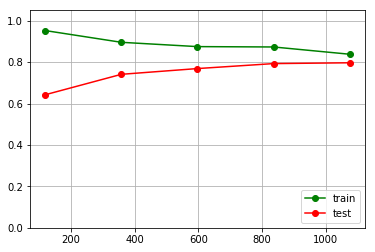

In [24]:
pylab.grid(True)
pylab.plot(train_sizes, train_scores.mean(axis = 1), 'g-', marker='o', label='train')
pylab.plot(train_sizes, test_scores.mean(axis = 1), 'r-', marker='o', label='test')
pylab.ylim((0.0, 1.05))
pylab.legend(loc='lower right')

In [25]:
scoring_5 = model_selection.cross_val_score(rf_classifier_low_depth, X, y, cv=10)
scoring_5.mean()

0.794715656041865

In [26]:
rf_classifier = ensemble.RandomForestClassifier(n_estimators = 50, max_depth = 10, random_state = 1)

In [27]:
train_sizes, train_scores, test_scores = model_selection.learning_curve(rf_classifier, X, y, 
                                                                       train_sizes=np.arange(0.1,1, 0.2), 
                                                                       cv=3, scoring='accuracy')

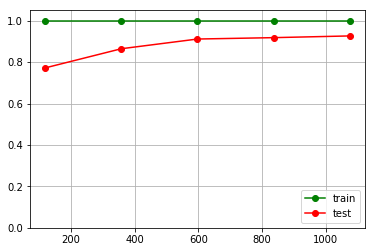

In [28]:
pylab.grid(True)
pylab.plot(train_sizes, train_scores.mean(axis = 1), 'g-', marker='o', label='train')
pylab.plot(train_sizes, test_scores.mean(axis = 1), 'r-', marker='o', label='test')
pylab.ylim((0.0, 1.05))
pylab.legend(loc='lower right')

In [29]:
scoring_6 = model_selection.cross_val_score(rf_classifier, X, y, cv=10)
scoring_6.mean()

0.9494534874161682

На основе наблюдений выпишите через пробел номера правильных утверждений из приведенных ниже в порядке возрастания номера (это будет ответ в п.5)

1) Случайный лес сильно переобучается с ростом количества деревьев - Неверно

2) При очень маленьком числе деревьев (5, 10, 15), случайный лес работает хуже, чем при большем числе деревьев  - Верно

3) С ростом количества деревьев в случайном лесе, в какой-то момент деревьев становится достаточно для высокого качества классификации, а затем качество существенно не меняется. - Верно

In [30]:
rf_classifier_few_estimators = ensemble.RandomForestClassifier(n_estimators = 10, max_depth = 10, random_state = 1)
model_selection.cross_val_score(rf_classifier_few_estimators, X, y, cv=10).mean()

0.9305333909763152

In [31]:
rf_classifier_many_estimators = ensemble.RandomForestClassifier(n_estimators = 100, max_depth = 10, random_state = 1)
model_selection.cross_val_score(rf_classifier_many_estimators, X, y, cv=10).mean()

0.9499538975818241

4) При большом количестве признаков (для данного датасета - 40, 50) качество классификации становится хуже, чем при малом количестве признаков (5, 10). Это связано с тем, что чем меньше признаков выбирается в каждом узле, тем более различными получаются деревья (ведь деревья сильно неустойчивы к изменениям в обучающей выборке), и тем лучше работает их композиция. - Верно

5) При большом количестве признаков (40, 50, 60) качество классификации лучше, чем при малом количестве признаков (5, 10). Это связано с тем, что чем больше признаков - тем больше информации об объектах, а значит алгоритм может делать прогнозы более точно. - Неверно

In [32]:
rf_classifier_many_features = ensemble.RandomForestClassifier(n_estimators = 50, max_depth = 10, 
                                                              max_features = 50, random_state = 1)
model_selection.cross_val_score(rf_classifier_many_features, X, y, cv=10).mean()

0.9293623435218972

In [33]:
rf_classifier_few_features = ensemble.RandomForestClassifier(n_estimators = 50, max_depth = 10, 
                                                            max_features = 5, random_state = 1)
model_selection.cross_val_score(rf_classifier_few_features, X, y, cv=10).mean()

0.9439299391302087

6) При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса намного лучше, чем без ограничения глубины, т.к. деревья получаются не переобученными. С ростом глубины деревьев качество ухудшается. - Неверно точно

7) При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса заметно хуже, чем без ограничений, т.к. деревья получаются недообученными. С ростом глубины качество сначала улучшается, а затем не меняется существенно, т.к. из-за усреднения прогнозов и различий деревьев их переобученность в бэггинге не сказывается на итоговом качестве (все деревья преобучены по-разному, и при усреднении они компенсируют переобученность друг-друга). - Верно точно

In [34]:
rf_classifier_without = ensemble.RandomForestClassifier(n_estimators = 50, random_state = 1)
model_selection.cross_val_score(rf_classifier_without, X, y, cv=10).mean()

0.9566566639850216

In [35]:
rf_classifier_with = ensemble.RandomForestClassifier(n_estimators = 50, max_depth = 5, random_state = 1)
model_selection.cross_val_score(rf_classifier_with, X, y, cv=10).mean()

0.9105225241406327

In [36]:
with open("5.txt", "w") as fout:
    fout.write("2 3 4 7")